In [17]:
#%pip install seaborn

In [1]:
import numpy as np
import pandas as pd

# from tqdm.notebook import tqdm
from tqdm import tqdm
import pickle
import gc
import time
# from time import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNetCV

from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [4]:
def exec_time(start_time):
    """Execution time in minutes"""
    return (time.time()-start_time)//60

# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [5]:
# Will we save intermediate models?
save_models = True

In [6]:
all_data = pd.read_parquet('data/all_data.parquet')
# print('Columns:', all_data.columns)
print('all_data coulumns =', list(all_data.columns))
all_data.info()
all_data

all_data coulumns = ['shop_id', 'item_id', 'date_block_num', 'item_category_id', 'target', 'target_shop_date', 'target_item_date', 'target_item_shop_date', 'target_item-cat_date', 'target_shop_item-cat_date', 'target_mean', 'target_shop_date_mean', 'target_item_date_mean', 'target_item_shop_date_mean', 'target_item-cat_date_mean', 'target_shop_item-cat_date_mean', 'target_lag_1', 'target_item-cat_date_lag_1', 'target_item-cat_date_mean_lag_1', 'target_item_date_lag_1', 'target_item_date_mean_lag_1', 'target_item_shop_date_lag_1', 'target_item_shop_date_mean_lag_1', 'target_mean_lag_1', 'target_shop_date_lag_1', 'target_shop_date_mean_lag_1', 'target_shop_item-cat_date_lag_1', 'target_shop_item-cat_date_mean_lag_1', 'target_lag_2', 'target_item-cat_date_lag_2', 'target_item-cat_date_mean_lag_2', 'target_item_date_lag_2', 'target_item_date_mean_lag_2', 'target_item_shop_date_lag_2', 'target_item_shop_date_mean_lag_2', 'target_mean_lag_2', 'target_shop_date_lag_2', 'target_shop_date_mean_

,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,12,37,1.0,1491.0,23.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,12,37,1.0,1491.0,62.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,12,37,1.0,1491.0,20.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,12,37,2.0,1491.0,42.0,2.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,12,37,1.0,1491.0,8.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,13,2,10,11,11,30,-0.475305
6639290,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,14,42,10,2,2,30,0.081167
6639291,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,124.0,124.0,20,13,2,10,22,22,30,0.155905
6639292,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,11,4,10,11,11,30,-0.091709


In [7]:
# list(all_data.columns)

In [8]:
# List of all lagged features

# We will drop these at fitting stage
to_drop_cols = ['target_shop_date', 'target_item_shop_date_mean', 'target_shop_item-cat_date_mean', 'target_shop_item-cat_date', 
                'target_item_date_mean', 'target_item-cat_date_mean', 'target_item-cat_date', 'target_item_shop_date', 
                'target_item_date', 'target', 'target_shop_date_mean', 'target_mean', 'date_block_num']

# Categorical features
cat_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 
                'type_code', 'subtype_code']

In [9]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()-1
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [10]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train =  all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =   all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)
X_target = all_data.loc[dates == dates.max()].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [11]:
X_train

,shop_id,item_id,item_category_id,target_lag_1,target_item-cat_date_lag_1,target_item-cat_date_mean_lag_1,target_item_date_lag_1,target_item_date_mean_lag_1,target_item_shop_date_lag_1,target_item_shop_date_mean_lag_1,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,37,0.0,9959.0,9959.0,24.0,24.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,37,0.0,9959.0,9959.0,28.0,28.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,37,1.0,9959.0,9959.0,12.0,12.0,1.0,1.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,37,0.0,9959.0,9959.0,42.0,42.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,37,0.0,9959.0,9959.0,15.0,15.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6186917,55,5230,26,1.0,6.0,6.0,1.0,1.0,1.0,1.0,...,0.0,0.0,27,6,61,7,8,8,31,0.058935
6186918,55,2757,26,4.0,6.0,6.0,4.0,4.0,4.0,4.0,...,0.0,0.0,27,6,61,7,8,8,31,-0.031505
6186919,55,7115,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27,7,61,7,0,0,31,0.000000
6186920,55,13095,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27,9,15,7,0,0,31,0.000000


In [12]:
# del all_data
gc.collect()

123

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [13]:
cat_columns = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'type_code', 'subtype_code']

print('cat_features =', cat_features)
print('cat_columns =', cat_columns)
for cat in cat_columns:
    print('for category ', cat, 'found unique values:', X_train[cat].unique().shape[0])

cat_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'type_code', 'subtype_code']
cat_columns = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'type_code', 'subtype_code']
for category  shop_id found unique values: 54
for category  item_id found unique values: 16561
for category  item_category_id found unique values: 79
for category  city_code found unique values: 31
for category  type_code found unique values: 19
for category  subtype_code found unique values: 62


In [14]:
linear_features = ['target_lag_1', 'target_item-cat_date_mean_lag_1', 
                   'target_item_date_mean_lag_1', 
                   'target_item_shop_date_mean_lag_1', 'target_mean_lag_1',
                   'target_shop_date_mean_lag_1', 'target_shop_item-cat_date_mean_lag_1', 
                   'target_lag_2', 'target_item-cat_date_mean_lag_2', 
                   'target_item_date_mean_lag_2', 'target_item_shop_date_mean_lag_2', 
                   'target_mean_lag_2', 'target_shop_date_mean_lag_2', 
                   'target_shop_item-cat_date_mean_lag_2',
                   'target_lag_3', 'target_item-cat_date_mean_lag_3', 'target_item_date_mean_lag_3', 
                   'target_item_shop_date_mean_lag_3', 'target_mean_lag_3', 'target_shop_date_mean_lag_3', 
                   'target_shop_item-cat_date_mean_lag_3',
                   'days', 'delta_price_lag']

In [32]:
%%time
model_lrc = make_pipeline(
    ColumnTransformer([
         #('one_hot_shop_id', OneHotEncoder(), ['shop_id']),
         ('one_hot_item_category_id', OneHotEncoder(handle_unknown='ignore'), ['item_category_id']),
         ('one_hot_city_code', OneHotEncoder(handle_unknown='ignore'), ['city_code']),
         ('one_hot_type_code', OneHotEncoder(handle_unknown='ignore'), ['type_code']),
         ('one_hot_subtype_code', OneHotEncoder(handle_unknown='ignore'), ['subtype_code']),
         ('to_pass', 'passthrough', linear_features)
        ], remainder='drop', n_jobs=-1, 
        sparse_threshold=0.3,
        verbose=True),
    MaxAbsScaler(),
    LinearRegression(n_jobs=-1),
    #ElasticNetCV(n_jobs=-1, random_state=43, max_iter=1000),
    #BayesianRidge(),
    verbose=True,
)
model_lrc.fit(X_train, y_train)
pred_lrc = model_lrc.predict(X_test)

print('\nTest R-squared for linreg is %f' % r2_score(y_test, pred_lrc))
print('Test RMSE linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_lrc)))

if save_models:
    pickle.dump(model_lrc, open('data/sa-model_lrc.pkl', "wb"))

[Pipeline] . (step 1 of 3) Processing columntransformer, total=   9.6s
[Pipeline] ...... (step 2 of 3) Processing maxabsscaler, total=   3.3s
[Pipeline] .. (step 3 of 3) Processing linearregression, total= 3.8min

Test R-squared for linreg is 0.277820
Test RMSE linreg is 0.965518
CPU times: user 4min 28s, sys: 1min 10s, total: 5min 38s
Wall time: 3min 59s


In [33]:
%%time
# BayesianRidge regression

model_br = make_pipeline(
    MinMaxScaler(), 
    BayesianRidge() #n_iter=1000, tol=0.0001)
)

model_br.fit(X_train, y_train)
pred_br = model_br.predict(X_test)

print(f'Test BayesianRidge linreg is {np.sqrt(mean_squared_error(y_test, pred_br)):.6f}' )

if save_models:
    pickle.dump(model_br, open('data/sa-model_br.pkl', "wb"))

Test BayesianRidge linreg is 0.964709
CPU times: user 2min 18s, sys: 10.8 s, total: 2min 29s
Wall time: 46.5 s


In [34]:
%%time
# MLPRegressor

# Subsample train set (using the whole data was taking too long).
# X_train_sampled = X_train[:2000000]
# y_train_sampled = y_train[:2000000]

model_mlp = make_pipeline(
    MinMaxScaler(),
    MLPRegressor(
        random_state=47, 
        verbose=True,
        early_stopping=True,
        n_iter_no_change=5,
        solver='adam',
#         hidden_layer_sizes=(300, 200 ,100), alpha=0.03, learning_rate='adaptive', learning_rate_init=0.0005, 
#         max_iter=200, momentum=0.9, nesterovs_momentum=True,
    ),
    verbose=True,
)
model_mlp.fit(X_train, y_train)
pred_mlp = model_mlp.predict(X_test)
train_mlp = model_mlp.predict(X_train)

print('\nTest R-squared is %f' % r2_score(y_test, pred_mlp))
print('Train R-squared is %f' % r2_score(y_train, train_mlp))
print(f'\nTest RMSE is {np.sqrt(mean_squared_error(y_test, pred_mlp)):.6}')
print(f'Train RMSE is {np.sqrt(mean_squared_error(y_train, train_mlp)):.6}')

if save_models:
    pickle.dump(model_mlp, open('data/sa-model_mlp.pkl', "wb"))

[Pipeline] ...... (step 1 of 2) Processing minmaxscaler, total=   3.2s
Iteration 1, loss = 0.40504097
Validation score: 0.433181
Iteration 2, loss = 0.39058312
Validation score: 0.446674
Iteration 3, loss = 0.38460675
Validation score: 0.451215
Iteration 4, loss = 0.38063824
Validation score: 0.458092
Iteration 5, loss = 0.37769591
Validation score: 0.461678
Iteration 6, loss = 0.37499981
Validation score: 0.465535
Iteration 7, loss = 0.37289355
Validation score: 0.463071
Iteration 8, loss = 0.37144070
Validation score: 0.468284
Iteration 9, loss = 0.37017903
Validation score: 0.470307
Iteration 10, loss = 0.36908898
Validation score: 0.470663
Iteration 11, loss = 0.36808530
Validation score: 0.473723
Iteration 12, loss = 0.36730323
Validation score: 0.470249
Iteration 13, loss = 0.36659489
Validation score: 0.475908
Iteration 14, loss = 0.36602787
Validation score: 0.477453
Iteration 15, loss = 0.36541763
Validation score: 0.479127
Iteration 16, loss = 0.36496405
Validation score: 0.4

## Tree-based models

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.927765
[200]	valid_0's l2: 0.876133
[300]	valid_0's l2: 0.86312
[400]	valid_0's l2: 0.857993
[500]	valid_0's l2: 0.857186
[600]	valid_0's l2: 0.860278
Early stopping, best iteration is:
[534]	valid_0's l2: 0.855937

Test R-squared for LightGBM is 0.336919
Test RMSE LightGBM is 0.925169

CPU times: user 17min 2s, sys: 8.58 s, total: 17min 11s
Wall time: 4min 43s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

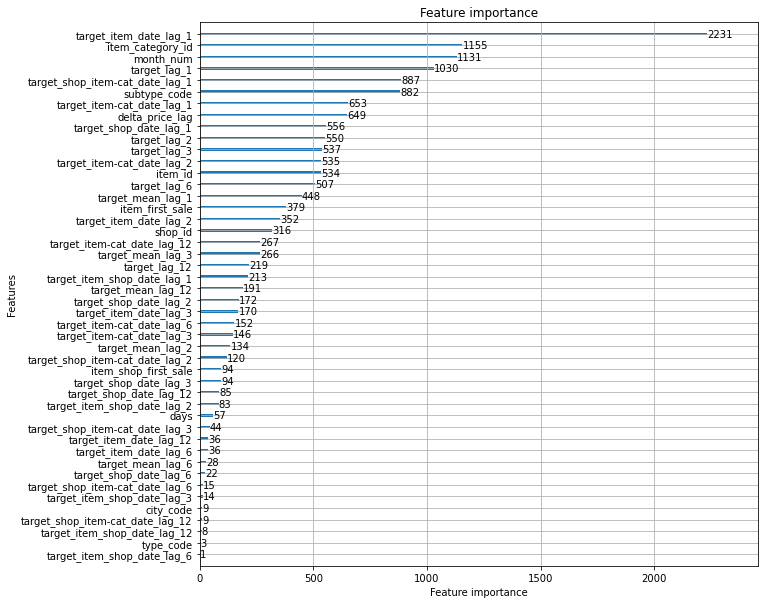

In [35]:
%%time
# LightGBM
model_lgb = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    #num_leaves=60,
    n_jobs=-1,
    objective='mse',
    random_state=43
)

model_lgb.fit(
    X_train, y_train, 
    eval_set=(X_test, y_test), 
    early_stopping_rounds=100,
    verbose=100
)
pred_lgb = model_lgb.predict(X_test)

print('\nTest R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))
print('Test RMSE LightGBM is %f' % np.sqrt(mean_squared_error(y_test, pred_lgb)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_lgb, open('data/sa-model_lgb.pkl', "wb"))

# Plot LightGBM features importance
fig, ax = plt.subplots(1,1,figsize=(10, 10))
lgb.plot_importance(booster=model_lgb, ax=ax)

In [36]:
#model_lgb.get_params()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.239925
0:	learn: 1.0910983	test: 1.0723190	best: 1.0723190 (0)	total: 1.18s	remaining: 19m 35s
10:	learn: 0.8898968	test: 0.9483907	best: 0.9483907 (10)	total: 13.3s	remaining: 19m 56s
20:	learn: 0.8646196	test: 0.9318014	best: 0.9318014 (20)	total: 27.8s	remaining: 21m 36s
30:	learn: 0.8524437	test: 0.9279715	best: 0.9279715 (30)	total: 42s	remaining: 21m 53s
40:	learn: 0.8413100	test: 0.9239631	best: 0.9228168 (38)	total: 57.2s	remaining: 22m 17s
50:	learn: 0.8349337	test: 0.9243863	best: 0.9228168 (38)	total: 1m 9s	remaining: 21m 28s
60:	learn: 0.8277864	test: 0.9222591	best: 0.9214261 (57)	total: 1m 23s	remaining: 21m 25s
70:	learn: 0.8221631	test: 0.9205535	best: 0.9205535 (70)	total: 1m 37s	remaining: 21m 17s
80:	learn: 0.8173175	test: 0.9210648	best: 0.9205535 (70)	total: 1m 51s	remaining: 21m 8s
90:	learn: 0.8134193	test: 0.9204401	best: 0.9204401 (90)	total: 2m 5s	remaining: 20m 51s
100:	learn: 0.8100206	test: 0.9199405	best: 0.9197436 (98)	total: 2m 19s

<AxesSubplot:title={'center':'Feature importances'}, ylabel='Feature Id'>

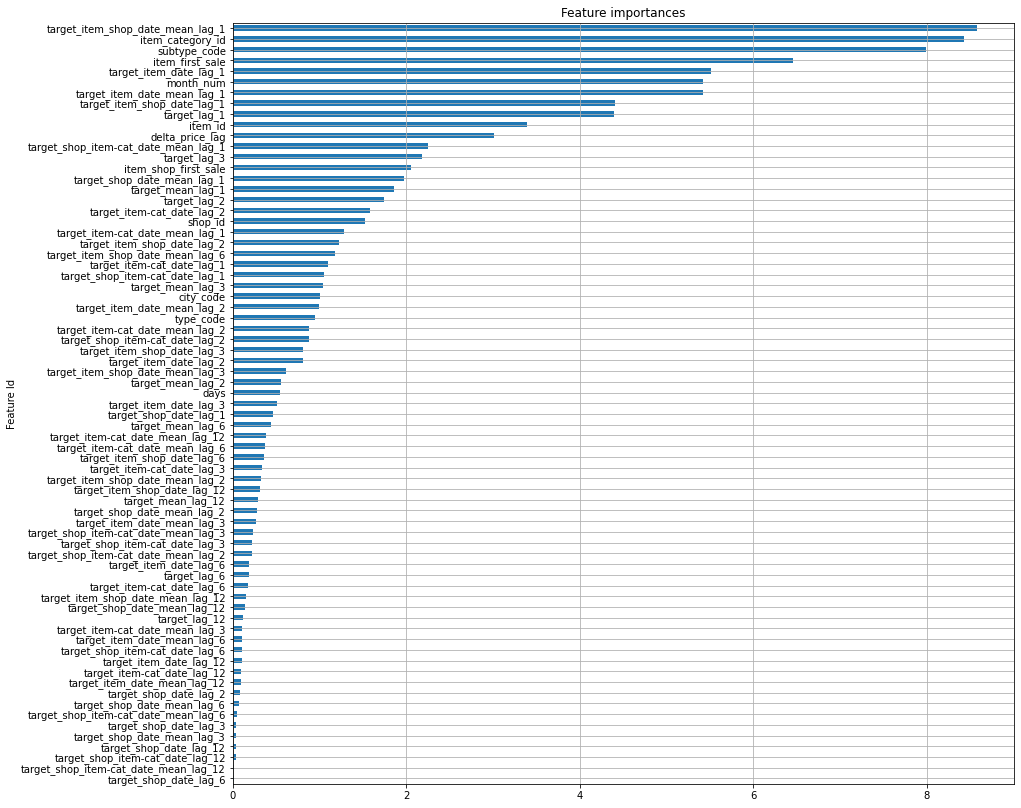

In [37]:
%%time
# Catboost

model_cbr = cb.CatBoostRegressor(
    loss_function='RMSE',
    #cat_features=cat_features,
    #l2_leaf_reg=6,
    depth=8,
    #learning_rate=0.1,
    #iterations=10000,
    iterations=1000,
    task_type='CPU',
    random_state=43,
)
model_cbr.fit(
    X_train, y_train, 
    eval_set=(X_test, y_test), 
    verbose=10, 
    #early_stopping_rounds=500,
    early_stopping_rounds=30,
    plot=True,
)
pred_cb = model_cbr.predict(X_test)

print('\nTest R-squared for CatBoost is %f' % r2_score(y_test, pred_cb))
print('Test RMSE CatBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_cb)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_cbr, open('data/sa-model_cbr.pkl', "wb"))

# Plot CatBoost features importance
f_importance = model_cbr.get_feature_importance(prettified=True)
f_importance[f_importance['Importances']>0].sort_values(by='Importances', ascending=True).set_index('Feature Id').plot(
    kind='barh', figsize=(14,14), legend=False, grid=True, title="Feature importances");

In [38]:
# model_cbr.get_all_params()

[23:08:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.05679	validation_1-rmse:1.05128
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[5]	validation_0-rmse:0.86719	validation_1-rmse:0.93073
[10]	validation_0-rmse:0.84523	validation_1-rmse:0.92384
[15]	validation_0-rmse:0.82992	validation_1-rmse:0.92417
[20]	validation_0-rmse:0.82328	validation_1-rmse:0.92267
[25]	validation_0-rmse:0.81744	validation_1-rmse:0.91946
[30]	validation_0-rmse:0.81306	validation_1-rmse:0.91538
[35]	validation_0-rmse:0.81044	validation_1-rmse:0.91351
[40]	validation_0-rmse:0.80539	validation_1-rmse:0.91200
[45]	validation_0-rmse:0.80307	validation_1-rmse:0.910

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

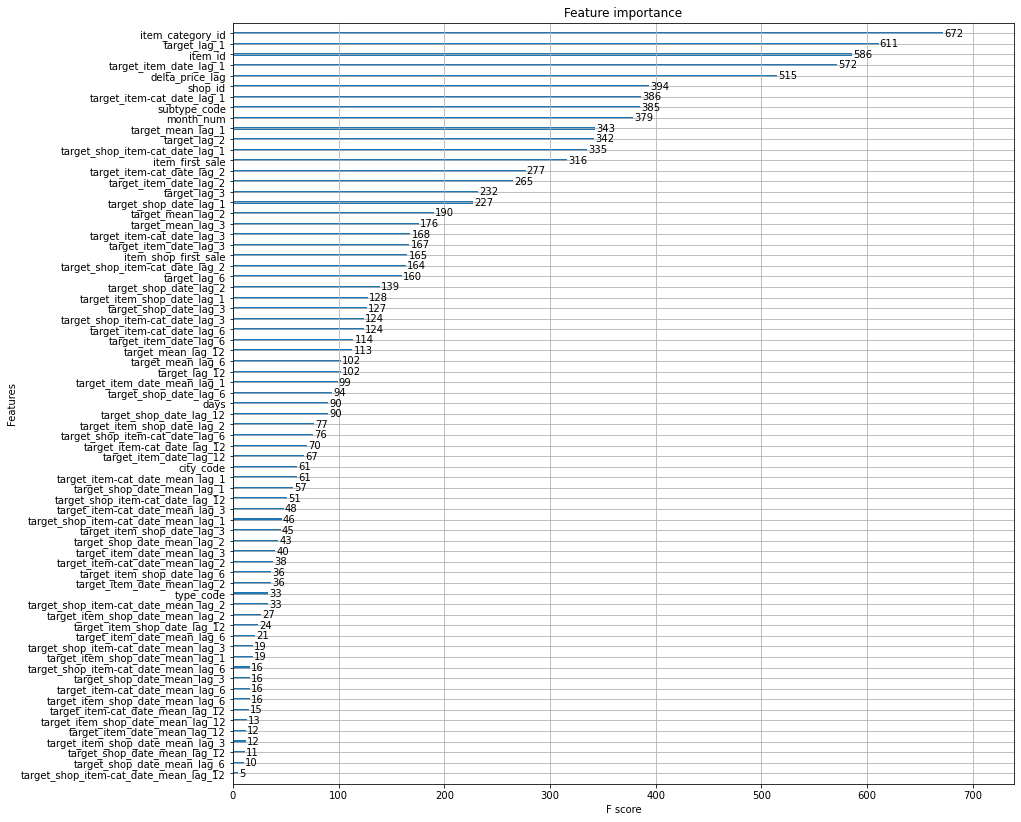

In [39]:
%%time
# xgboost
model_xgb = xgb.XGBRegressor(
    n_jobs=4, 
    random_state=43,
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
)

model_xgb.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric="rmse", 
    verbose=5, 
    early_stopping_rounds = 20
)
pred_xgb = model_xgb.predict(X_test)

print('\nTest R-squared for XGBoost is %f' % r2_score(y_test, pred_xgb))
print('Test RMSE XGBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_xgb)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_xgb, open('data/sa-model_xgb.pkl', "wb"))

# Plot XGBoost features importance
fig, ax = plt.subplots(1,1,figsize=(14, 14))
xgb.plot_importance(booster=model_xgb, ax=ax)

In [40]:
%%time
# RandomForest

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:2000000]
y_train_sampled = y_train[:2000000]

model_rf = RandomForestRegressor(
    criterion='mse',
    n_jobs=-1,
    n_estimators=50, 
    max_depth=8,
    random_state=47,
    verbose=10,
)

model_rf.fit(
    X_train_sampled, y_train_sampled, 
)
pred_rf = model_rf.predict(X_test)

print('\nTest R-squared for RandomForestRegressor is %f' % r2_score(y_test, pred_rf))
print('Test RMSE RandomForest is %f' % np.sqrt(mean_squared_error(y_test, pred_rf)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_rf, open('data/sa-model_rf.pkl', "wb"))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min


building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min


building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min


building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.2min


building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.7min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.8min


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50

Test R-squared for RandomForestRegressor is 0.308643
Test RMSE RandomForest is 0.944688

CPU times: user 23min 33s, sys: 7.67 s, total: 23min 41s
Wall time: 6min 49s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


In [15]:
# KNeighborsRegressor
knn_features = ['target_item_date_lag_1', 'delta_price_lag', 
                'target_lag_1', 'target_lag_2', 'item_category_id', 'subtype_code', 'target_mean_lag_1',
                'target_item_date_mean_lag_1',  'target_item_shop_date_lag_1',
               'target_shop_date_mean_lag_1']

In [42]:
%%time
# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:400000]
y_train_sampled = y_train[:400000]

model_knr =  make_pipeline(
    ColumnTransformer([
         ('to_pass', 'passthrough', knn_features)
        ], remainder='drop', n_jobs=-1, verbose=True),
    MinMaxScaler(),
    KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
          weights='uniform')
)
model_knr.fit(X_train_sampled, y_train_sampled)
print('Model fitting done')
pred_knr = model_knr.predict(X_test)

print(f'Test KNeighborsRegressor is {np.sqrt(mean_squared_error(y_test, pred_knr)):.6f}')

if save_models:
    pickle.dump(model_knr, open('data/sa-model_knr.pkl', "wb"))

Model fitting done
Test KNeighborsRegressor is 0.991195
CPU times: user 4min 16s, sys: 1.2 s, total: 4min 17s
Wall time: 3min 37s


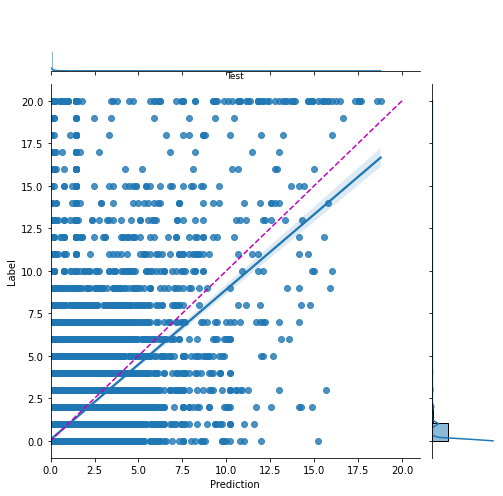

In [43]:
model_performance_sc_plot(pred_knr, y_test, 'Test')

## Load pickled predictors 

In [16]:
# Load pickled predictors
if save_models:
    model_lrc  = pickle.load(open('data/sa-model_lrc.pkl', "rb"))    # LinearRegression
    model_mlp  = pickle.load(open('data/sa-model_mlp.pkl', "rb"))   # MLPRegressor
    model_lgb  = pickle.load(open('data/sa-model_lgb.pkl', "rb"))   # LightGBM
    model_cbr  = pickle.load(open('data/sa-model_cbr.pkl', "rb"))   # CatBoost
    model_xgb  = pickle.load(open('data/sa-model_xgb.pkl', "rb"))   # xgboost
    model_br   = pickle.load(open('data/sa-model_br.pkl', "rb"))    # BayesianRidge
    model_rf   = pickle.load(open('data/sa-model_rf.pkl', "rb"))    # RandomForestRegressor
    model_knr  = pickle.load(open('data/sa-model_knr.pkl', "rb"))  # KNeighborsRegressor
    

In [17]:
%%time
# Make predictions for test data (Kaggle's test dataset)
test_lrc = model_lrc.predict(X_test)
test_mlp = model_mlp.predict(X_test)
test_lgb = model_lgb.predict(X_test)
test_cbr = model_cbr.predict(X_test)
test_xgb = model_xgb.predict(X_test)
test_br  = model_br.predict(X_test)
test_rf  = model_rf.predict(X_test)
test_knr = model_knr.predict(X_test)

X_test_level2 = np.c_[test_lrc, test_mlp, test_lgb, test_cbr, test_xgb,
                      test_br, test_knr]
print('Test L2 data shape:', X_test_level2.shape)
X_test_level2_df = pd.DataFrame(
    X_test_level2, 
    columns=['test_lrc', 'test_mlp', 'test_lgb', 'test_cbr', 
             'test_xgb', 'test_br', 'test_knr']
)
X_test_level2_df.to_parquet('data/X_test_level2.parquet')
X_test_level2_df

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


Test L2 data shape: (238172, 7)
CPU times: user 1min 8s, sys: 2.24 s, total: 1min 10s
Wall time: 22.9 s


,test_lrc,test_mlp,test_lgb,test_cbr,test_xgb,test_br,test_knr
0,0.000428,0.186176,0.107310,0.112270,0.151587,-0.036614,0.000000
1,0.097112,0.265126,0.161124,0.172602,0.161356,0.047865,0.000000
2,0.213008,0.075473,0.038950,0.038362,-0.007963,0.172836,0.777778
3,0.102523,0.274421,0.206999,0.155187,0.214454,0.100093,0.000000
4,0.004333,0.111519,0.068687,0.038960,0.060059,-0.038549,0.111111
...,...,...,...,...,...,...,...
238167,2.234519,2.834110,2.870174,4.601828,2.924398,2.350054,1.555556
238168,0.089447,1.538540,0.425080,-0.129762,1.071386,0.366720,1.666667
238169,0.570705,0.349852,0.663869,0.394494,0.407585,0.818224,0.444444
238170,2.074225,1.558079,2.216207,1.985032,2.733285,2.298733,2.222222


In [22]:
%%time
# Make prediction for target data
target_lrc = model_lrc.predict(X_target)
target_mlp = model_mlp.predict(X_target)
target_lgb = model_lgb.predict(X_target)
target_cbr = model_cbr.predict(X_target)
target_xgb = model_xgb.predict(X_target)
target_br  = model_br.predict(X_target)
target_rf  = model_rf.predict(X_target)
target_knr = model_knr.predict(X_target)

X_target_level2 = np.c_[target_lrc, target_mlp, target_lgb, target_cbr, target_xgb, 
                        target_br, target_rf, target_knr]
print('Target L2 data shape:', X_target_level2.shape)

X_target_level2_df = pd.DataFrame(
    X_target_level2, 
    columns=['target_lrc', 'target_mlp', 'target_lgb', 'target_cbr', 'target_xgb', 
                        'target_br', 'target_rf', 'target_knr']
)
X_target_level2_df.to_parquet('data/X_target_level2.parquet')
X_target_level2_df

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


Target L2 data shape: (214200, 8)
CPU times: user 1min 7s, sys: 1.8 s, total: 1min 9s
Wall time: 21.3 s


,target_lrc,target_mlp,target_lgb,target_cbr,target_xgb,target_br,target_rf,target_knr
0,0.518025,0.529242,0.560219,0.501068,0.579230,0.545016,0.178667,0.333333
1,0.295186,0.124622,0.432378,0.274144,0.873897,0.328479,0.258745,0.000000
2,1.019672,1.318999,1.148340,1.586987,1.973421,1.185565,1.727063,0.222222
3,0.305741,0.483769,0.396388,0.602930,0.992429,0.317187,0.355321,0.222222
4,0.772520,2.878512,3.608086,3.867211,2.080476,0.408126,2.118644,1.444444
...,...,...,...,...,...,...,...,...
214195,0.415647,0.091744,0.129604,0.050721,0.044892,0.430344,0.045179,0.000000
214196,0.104679,0.222466,0.038961,0.038873,0.049970,0.159952,0.045179,0.000000
214197,0.074545,0.137348,0.040442,0.056659,0.047547,-0.026862,0.045179,0.111111
214198,0.043953,0.045755,0.036372,0.031345,0.022161,0.052216,0.045179,0.000000


# K-Fold CV Stage

In [23]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]
print('dates_train_level2:\n', dates_train_level2, sep='')
# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

dates_train_level2:
2263525    30
2263526    30
2263527    30
2263528    30
2263529    30
           ..
6186917    31
6186918    31
6186919    31
6186920    31
6186921    31
Name: date_block_num, Length: 1376192, dtype: int32


In [24]:
y_train_level2, y_train_level2.shape

(array([1., 1., 1., ..., 1., 1., 4.], dtype=float32), (1376192,))

In [25]:
# del cX_test
# del cX_pred

In [ ]:
%%time
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

M=15

X_train_2 = []

# Now fill `X_train_level2` with metafeatures
#for cur_block_num in tqdm([27, 28, 29, 30, 31, 32]):
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print('\nCurrent block:', cur_block_num)
    cdates = (dates <  cur_block_num)
#     cX_test = all_data.loc[cdates].drop(to_drop_cols, axis=1)
#     cy_train = all_data.loc[cdates, 'target'].values
#     cX_pred = all_data.loc[dates==cur_block_num].drop(to_drop_cols, axis=1)
    cX_train = all_data.loc[cdates].drop(to_drop_cols, axis=1)
    cy_train = all_data.loc[cdates, 'target'].values
    cX_test = all_data.loc[dates==cur_block_num].drop(to_drop_cols, axis=1)
    cy_test = all_data.loc[dates==cur_block_num, 'target'].values
    
    # Linear Regression
    ts = time.time()
    model_lrc_cv = make_pipeline(
        ColumnTransformer([
             #('one_hot_shop_id', OneHotEncoder(), ['shop_id']),
             ('one_hot_item_category_id', OneHotEncoder(handle_unknown='ignore'), ['item_category_id']),
             ('one_hot_city_code', OneHotEncoder(handle_unknown='ignore'), ['city_code']),
             ('one_hot_type_code', OneHotEncoder(handle_unknown='ignore'), ['type_code']),
             ('one_hot_subtype_code', OneHotEncoder(handle_unknown='ignore'), ['subtype_code']),
             ('to_pass', 'passthrough', linear_features)
            ], remainder='drop', n_jobs=-1, 
            sparse_threshold=0.3,
            verbose=False),
        MaxAbsScaler(),
        LinearRegression(n_jobs=-1),
        verbose=False,
    )
    model_lrc_cv.fit(cX_train, cy_train)
    pred_lrc_cv = model_lrc_cv.predict(cX_test)
    print(f'Test RMSE LinearRegression: {rmse(cy_test, pred_lrc_cv):.6f}',
          f'execution time {exec_time(ts)} minutes')
 
    # BayesianRidge regression
    ts = time.time()
    model_br_cv = make_pipeline(
        MinMaxScaler(), 
        BayesianRidge()
    )
    model_br_cv.fit(cX_train, cy_train)
    pred_br_cv = model_br_cv.predict(cX_test)
    print(f'Test RMSE BayesianRidge: {rmse(cy_test, pred_br_cv):.6f}',
          f'execution time {exec_time(ts)} minutes')
   
    # MLPRegressor 
    ts = time.time()
    model_mlp_cv = make_pipeline(
        MinMaxScaler(),
        MLPRegressor(
            random_state=43, 
            verbose=False,
            early_stopping=True,
            n_iter_no_change=5,
            solver='adam',
        ),
        #verbose=True,
    )
    model_mlp_cv.fit(cX_train, cy_train)
    pred_mlp_cv = model_mlp_cv.predict(cX_test)
    #train_mlp_cv = model_mlp_cv.predict(cX_train)
    print(f'Test RMSE MLPRegressor: {rmse(cy_test, pred_mlp_cv):.6}',
          f'execution time {exec_time(ts)} minutes')

    # LightGBM
    ts = time.time()
    model_lgb_cv = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=10,
        n_jobs=-1,
        objective='mse',
        random_state=43
    )
    model_lgb_cv.fit(
        cX_train, cy_train, 
        eval_set=(cX_test, cy_test), 
        early_stopping_rounds=100,
        verbose=0
    )
    pred_lgb_cv = model_lgb_cv.predict(cX_test)
    print(f'Test RMSE LightGBM: {rmse(cy_test, pred_lgb_cv):.6f}',
          f'execution time {exec_time(ts)} minutes')
    
    # Catboost
    ts = time.time()
    model_cbr_cv = cb.CatBoostRegressor(
        loss_function='RMSE',
        depth=8,
        iterations=1000,
        task_type='CPU',
        random_state=43,
    )
    model_cbr_cv.fit(
        cX_train, cy_train, 
        eval_set=(cX_test, cy_test), 
        verbose=0, 
        early_stopping_rounds=30,
        plot=False,
    )
    pred_cb_cv = model_cbr_cv.predict(cX_test)
    print(f'Test RMSE CatBoost: {rmse(cy_test, pred_cb_cv):.6f}',
         f'execution time {exec_time(ts)} minutes')
    
    # XGBoost
    ts = time.time()
    model_xgb_cv = xgb.XGBRegressor(
        n_jobs=8, 
        random_state=43,
        max_depth=8,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,
    )
    model_xgb_cv.fit(
        cX_train, cy_train, 
        eval_set=[(cX_test, cy_test)], 
        eval_metric="rmse", 
        verbose=0, 
        early_stopping_rounds = 20
    )
    pred_xgb_cv = model_xgb_cv.predict(cX_test)
    print(f'Test XGBoost RMSE = {rmse(cy_test, pred_xgb_cv):.6f}',
          f'execution time {exec_time(ts)} minutes')
    
    # RandomForest
    ts = time.time()
    model_rf_cv = RandomForestRegressor(
        criterion='mse',
        n_jobs=-1,
        n_estimators=50, 
        max_depth=8,
        random_state=47,
        verbose=0,
    )
    model_rf_cv.fit(
        cX_train, cy_train, 
    )
    pred_rf_cv = model_rf_cv.predict(cX_test)
    print(f'Test RandomForest RMSE = {rmse(cy_test, pred_rf_cv):.6f}',
         f'execution time {exec_time(ts)} minutes')
    
    # KNeighborsRegressor
    ts = time.time()
    # Subsample train set (using the whole data was taking too long).
    X_train_sampled = cX_train[:400000]
    y_train_sampled = cy_train[:400000]
    model_knr_cv =  make_pipeline(
        ColumnTransformer([
             ('to_pass', 'passthrough', knn_features)
            ], remainder='drop', n_jobs=-1, verbose=False),
        MinMaxScaler(),
        KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
              metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
              weights='uniform')
    )
    model_knr_cv.fit(X_train_sampled, y_train_sampled)
    print('Model fitting done')
    pred_knr_cv = model_knr_cv.predict(cX_test)
    print(f'Test KNeighborsRegressor is {rmse(cy_test, pred_knr_cv):.6f}',
         f'execution time {exec_time(ts)} minutes')


    X_train_2.append(np.c_[pred_lrc_cv, pred_mlp_cv, pred_lgb_cv, pred_cb_cv, pred_xgb_cv,
                         pred_rf_cv, pred_knr_cv])
    
X_train_level2 = np.vstack(X_train_2)

pd.DataFrame(X_train_level2, 
             columns=['pred_lrc', 'pred_mlp', 'pred_lgb', 
                      'pred_cb_', 'pred_xgb',
                      'pred_rf', 'pred_knr']
            ).to_parquet('data/X_train_level2.parquet')


Current block: 27
Test RMSE LinearRegression: 0.947013 execution time 3.0 minutes
Test RMSE BayesianRidge: 0.931592 execution time 0.0 minutes


In [ ]:
X_train_level2 = pd.read_parquet('data/X_train_level2.parquet')
X_test_level2 = pd.read_parquet('data/X_test_level2.parquet')

In [ ]:
print('X_train_level2:\n', X_train_level2.head().to_string(), sep='')
print('X_test_level2:\n', X_test_level2.head().to_string(), sep='')

# Meta model

In [65]:
pd.DataFrame(X_test_level2)

,0,1,2,3,4,5,6,7
0,0.000428,0.186176,0.107310,0.112270,0.151587,-0.036614,-0.036614,0.000000
1,0.097112,0.265126,0.161124,0.172602,0.161356,0.047865,0.047865,0.000000
2,0.213008,0.075473,0.038950,0.038362,-0.007963,0.172836,0.172836,0.777778
3,0.102523,0.274421,0.206999,0.155187,0.214454,0.100093,0.100093,0.000000
4,0.004333,0.111519,0.068687,0.038960,0.060059,-0.038549,-0.038549,0.111111
...,...,...,...,...,...,...,...,...
238167,2.234519,2.834110,2.870174,4.601828,2.924398,2.350054,2.350054,1.555556
238168,0.089447,1.538540,0.425080,-0.129762,1.071386,0.366720,0.366720,1.666667
238169,0.570705,0.349852,0.663869,0.394494,0.407585,0.818224,0.818224,0.444444
238170,2.074225,1.558079,2.216207,1.985032,2.733285,2.298733,2.298733,2.222222


In [62]:
ts = time.time()
lr_meta = ElasticNetCV(
    n_jobs=-1, 
    random_state=43
)
lr_meta.fit(X_train_level2.values, y_train_level2)
pred_meta_lr = lr_meta.predict(X_test_level2)
print(f'Test RMSE ElasticNetCV L2: {rmse(y_test, pred_lrc_cv):.6f}',
      f'execution time {exec_time(ts)} minutes')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7 is different from 8)

In [ ]:
# l2_model_cb.get_all_params()

## Prepare data to Kaggle

In [ ]:
# Make submission

# Insert your model here
pred_model = lr_meta # ElasticNetCV

tests = pd.read_csv('../readonly/final_project_data/test.csv.gz')
# export_pred = l2_model_lr.predict(X_target_level2)

export_pred = pred_model.predict(X_target_level2)
# export_pred = np.round(export_pred)
kaggle_data = tests.merge(
    pd.DataFrame(np.c_[X_target[['shop_id', 'item_id']], export_pred], 
                 columns=['shop_id', 'item_id', 'item_cnt_month']) )
kaggle_data['item_cnt_month'].clip(0, 20, inplace=True)

kaggle_data[['ID', 'item_cnt_month']].to_csv('simple_ensemble.csv', index=False)

print('kaggle_data shape:', kaggle_data.shape)
kaggle_data